In [4]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
sys.path.append('../common_scripts')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os


from common_processing_functions import apply_cosine_taper
from common_processing_functions import butterworth_filter

from zenodo_get import zenodo_get

In [7]:
## Downloading the physical features 

# Define the Zenodo record DOI
doi = '10.5281/zenodo.11193341'  ## This is for physical features


## This is doi for tsfel features of 50s window length - 10.5281/zenodo.10689673
## This is doi for tsfel features of 150s window length - 10.5281/zenodo.10689824

# Download files from the Zenodo record
files = zenodo_get([doi])


Title: Physical Features for my study on Automatic Seismic Event Classification System in Pacific Northwest (Origin time - 50, +100)
Keywords: 
Publication date: 2024-05-14
DOI: 10.5281/zenodo.11193341
Total size: 179.7 MB

Link: https://zenodo.org/record/11193341/files/new_physical_features_comcat_z_explosion_50_100.csv   size: 11.7 MB

Checksum is correct. (b98eb04772713626a9102d11f50cdddb)

Link: https://zenodo.org/record/11193341/files/new_physical_features_noise_z_50_100.csv   size: 38.1 MB

Checksum is correct. (36a8f8c93828712699c56682c8403f56)

Link: https://zenodo.org/record/11193341/files/new_physical_features_earthquake_z_part3_50_100.csv   size: 35.9 MB

Checksum is correct. (495e768402c1128600997c7cf06b9c32)

Link: https://zenodo.org/record/11193341/files/new_physical_features_earthquake_z_part2_50_100.csv   size: 18.5 MB

Checksum is correct. (aff05badde45433740fd068159ab4f2b)

Link: https://zenodo.org/record/11193341/files/new_physical_features_earthquake_z_part1_50_100.

## Loading physical features

In [11]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('new_physical_features_exotic_z_50_100.csv')

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']



# features of noise
features_noise_physical = pd.read_csv('new_physical_features_noise_z_50_100.csv')


# features of explosion
features_explosion_physical = pd.read_csv('new_physical_features_comcat_z_explosion_50_100.csv')

# features of earthquakes
features_eq1 = pd.read_csv('new_physical_features_earthquake_z_part1_50_100.csv')
features_eq2 = pd.read_csv('new_physical_features_earthquake_z_part2_50_100.csv')
features_eq3 = pd.read_csv('new_physical_features_earthquake_z_part3_50_100.csv')
features_eq4 = pd.read_csv('new_physical_features_earthquake_z_part4_50_100.csv')

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

In [14]:
features_all = pd.concat([features_surface_physical, features_noise_physical, features_explosion_physical, features_earthquake_physical])
features_all = features_all.drop(['Unnamed: 0'], axis = 1)
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 240326 events and each event have 64 features


In [40]:
features_surface_physical

,Unnamed: 0,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,Gamma,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,E_20_50,Kurto_20_50,serial_no,source
0,0,180.0,12.645280,200.352346,0.858736,28.793301,7.668133,0.390621,2.585658,715,19.701650,-17.276828,-1.140351,0.356358,3.380575,140.872162,3.283151,2.592947e-08,1.249601e-07,3.953484,3.921842,27.864289,2,2.470174,168.509470,0.504488,0.002838,0.000020,3.376450,3.590875,NaN,31.254228,14.040830,33.069641,6.349795e+08,19,15,21,1.266667,0.904762,28,23,1.217391,0.005915,0.006055,-0.900972,0.226054,-0.674918,0.633949,0.050133,9.024483,0.050136,83.16,-0.061608,26.195223,0.729668,24.923665,0.861922,27.177353,-0.541525,15.873059,0,0,0,surface
1,0,180.0,13.461313,35.477503,0.771131,35.334781,15.000947,-0.061877,3.794186,975,-0.449144,2.914607,-0.154101,0.310949,3.522407,102.379451,4.316427,5.975669e-10,8.986044e-08,5.563720,5.479335,30.966540,9,8.123469,174.403576,1.695741,0.000206,0.000173,5.133265,5.384881,NaN,51.486993,32.119514,26.692855,7.047854e+08,21,19,19,1.105263,1.105263,23,25,0.920000,0.003945,0.004060,0.420442,-1.031675,-0.611232,0.601280,0.044667,8.040551,0.044670,78.37,-0.153868,0.670316,0.482362,23.637238,0.863833,39.405427,-0.145915,35.040261,0,0,1,surface
2,0,180.0,15.241255,40.331077,0.728111,49.264073,16.245857,0.351163,4.029025,921,1.663099,-1.539232,-1.080473,0.254206,2.916232,62.921844,4.077551,5.253448e-10,8.992312e-08,5.131268,5.071497,30.966317,8,5.257488,144.819254,0.977894,0.000150,0.000126,4.627947,4.905820,NaN,16.207287,20.959667,51.109078,2.327735e+09,23,22,20,1.045455,1.150000,26,19,1.368421,0.002465,0.002542,0.929428,-0.397909,0.531518,0.490283,0.032168,5.790593,0.032170,75.84,-0.210914,2.702535,0.487304,35.650523,0.655823,48.595911,-0.313761,47.290703,0,0,2,surface
3,0,180.0,14.337339,197.728989,0.804150,35.797302,14.663002,-0.078677,3.718896,715,-2.917800,3.413944,-0.854671,0.343710,3.200182,129.586414,3.272040,4.097438e-08,1.489769e-07,4.100101,4.031940,27.574289,7,3.467016,158.956205,1.037340,0.003699,0.000012,3.456613,3.595363,NaN,26.421618,13.191177,35.874665,2.339814e+08,25,18,21,1.388889,1.190476,26,24,1.083333,0.007361,0.007512,-0.011273,0.983937,0.972664,0.626016,0.043663,7.859834,0.043666,80.23,-0.408073,24.731721,0.621595,39.219260,0.826706,33.031724,-0.449186,14.280189,0,0,3,surface
4,0,180.0,11.513205,45.625513,0.774098,36.491472,10.102242,0.843201,3.240009,1131,0.484249,-2.080606,-0.232744,0.276535,4.030294,102.317378,4.466419,5.520475e-10,7.587667e-08,6.308840,6.184135,30.966379,4,7.724923,198.266989,3.228602,0.000217,0.000183,6.018274,6.308705,NaN,24.003029,47.331791,26.093091,6.565795e+08,21,19,16,1.105263,1.312500,22,24,0.916667,0.003615,0.003742,1.397772,-0.448042,0.949730,0.514109,0.044654,8.038139,0.044656,78.54,-0.178223,1.544576,0.375944,18.196225,0.864662,38.090518,0.120403,34.137077,0,0,4,surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8907,0,180.0,7.604713,15.499950,0.823523,15.271351,5.629357,0.393230,2.429711,595,-7.135025,12.516359,-0.570056,0.375777,5.355032,181.784306,2.144325,1.905683e-07,9.392973e-08,4.116181,4.045088,27.236236,1,4.780565,266.050175,1.648759,0.031023,0.000214,3.268414,3.694381,NaN,15.172976,0.338803,50.96469

## Removing the downloaded files to clean up the directory

In [41]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)


## Preprocessing the input features

In [42]:
# dropping the columns that contain NaNs
features_all = features_all.dropna(axis = 1)

# dropping the rows that contains NaNs
features_all = features_all.dropna()


## dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()


## dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240326 events and each event have 61 features


## Dropping the columns that contain same values for all the events, as these features do not really contribute in classification

In [18]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index


# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240326 events and each event have 61 features


## Data Cleaning (Optional)

In [48]:
"""

df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 10

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(len(features_all))
print(len(outliers_removed_df))
"""

240326
238213


# Removing Highly Correlated Features

In [85]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
correlation_matrix = df.corr().abs()
highly_correlated = np.where(correlation_matrix >= 0.8)
columns = df.columns

to_drop = []
for i, j in zip(*highly_correlated):
    if i != j and i not in to_drop and j not in to_drop:
        to_drop.append(columns[j])

df_filtered = df.drop(to_drop, axis=1)


In [87]:
df_filtered['serial_no'] = features_all['serial_no'].values
df_filtered['source'] = features_all['source'].values

In [88]:
## Lets not remove the outliers for a bit
outliers_removed_df = df_filtered

In [89]:
print(f'So we now have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')

So we now have 240326 events and each event have 35 features


In [90]:
outliers_removed_df

,Window_Length,RappMaxMedian,SkewSig,Energy1/3Cor,Energy2/3Cor,int_ratio,FMaxFFT,MedianFFT,VarFFT,Fquart3,NPeakFFT,E2FFT,E3FFT,E4FFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Envelope_Rise_Time,Kurto_0.1_1,Kurto_1_3,Kurto_10_20,serial_no,source
0,180.0,200.352346,0.390621,19.701650,-17.276828,-1.140351,3.283151,2.592947e-08,1.249601e-07,27.864289,2,0.504488,0.002838,0.000020,14.040830,33.069641,6.349795e+08,19,15,21,1.266667,0.904762,28,23,1.217391,-0.900972,0.226054,-0.674918,0.633949,83.16,26.195223,24.923665,15.873059,0,surface
1,180.0,35.477503,-0.061877,-0.449144,2.914607,-0.154101,4.316427,5.975669e-10,8.986044e-08,30.966540,9,1.695741,0.000206,0.000173,32.119514,26.692855,7.047854e+08,21,19,19,1.105263,1.105263,23,25,0.920000,0.420442,-1.031675,-0.611232,0.601280,78.37,0.670316,23.637238,35.040261,1,surface
2,180.0,40.331077,0.351163,1.663099,-1.539232,-1.080473,4.077551,5.253448e-10,8.992312e-08,30.966317,8,0.977894,0.000150,0.000126,20.959667,51.109078,2.327735e+09,23,22,20,1.045455,1.150000,26,19,1.368421,0.929428,-0.397909,0.531518,0.490283,75.84,2.702535,35.650523,47.290703,2,surface
3,180.0,197.728989,-0.078677,-2.917800,3.413944,-0.854671,3.272040,4.097438e-08,1.489769e-07,27.574289,7,1.037340,0.003699,0.000012,13.191177,35.874665,2.339814e+08,25,18,21,1.388889,1.190476,26,24,1.083333,-0.011273,0.983937,0.972664,0.626016,80.23,24.731721,39.219260,14.280189,3,surface
4,180.0,45.625513,0.843201,0.484249,-2.080606,-0.232744,4.466419,5.520475e-10,7.587667e-08,30.966379,4,3.228602,0.000217,0.000183,47.331791,26.093091,6.565795e+08,21,19,16,1.105263,1.312500,22,24,0.916667,1.397772,-0.448042,0.949730,0.514109,78.54,1.544576,18.196225,34.137077,4,surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66677,150.0,34.391704,-0.815551,-1.289040,1.379836,-0.934198,6.272915,1.083760e-06,1.134259e-07,27.414076,2,7.969294,0.079965,0.000237,11.799931,35.148489,2.322118e+07,19,17,14,1.117647,1.357143,19,18,1.055556,0.032898,0.189533,0.222431,0.426996,56.00,0.915131,34.807347,73.805559,167961,earthquake
66678,150.0,27.497959,1.011079,0.835050,-2.065314,-0.404321,6.566229,2.730124e-06,6.785729e-08,27.069779,7,9.188297,0.124946,0.000619,12.478775,46.721793,1.727158e+06,19,17,17,1.117647,1.117647,19,17,1.117647,2.860482,-1.765616,1.094866,0.399459,57.64,1.129737,29.959693,99.593303,167962,earthquake
66679,150.0,15.431472,0.590854,-15.359710,-3.131539,4.904844,7.739484,1.484529e-06,7.045085e-08,27.528391,8,12.837742,0.120068,0.001180,32.221022,55.663573,1.353339e+07,19,17,18,1.117647,1.055556,22,14,1.571429,2.548154,-1.278492,1.269662,0.431022,58.69,0.362626,31.972912,90.376973,167963,earthquake
66680,150.0,9.284299,-0.359917,8.020415,-14.279975,-0.561655,7.226185,7.536134e-07,7.995738e-08,27.602133,1,15.070057,0.090826,0.001079,1.270633,22.221395,2.643034e+06,19,18,21,1.055556,0.904762,19,18,1.055556,0.470822,-0.673566,-0.202744,0.595805,60.02,0.162415,5.936017,17.774557,167964,earthquake


## Standardizing the features

In [53]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source'], axis = 1)
y = outliers_removed_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)


# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


## We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
#X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values

                       Feature          Mean       Std Dev
0                Window_Length  1.511125e+02  5.668954e+00
1                  RappMaxMean  1.052831e+01  9.096701e+00
2                RappMaxMedian  4.685032e+01  5.238700e+03
3                        AsDec  1.136528e+00  1.662045e+00
4                     KurtoSig  5.556736e+01  8.526405e+01
5                     KurtoEnv  2.268183e+01  2.326269e+01
6                      SkewSig -4.055249e-02  1.162093e+00
7                      SkewEnv  3.331290e+00  2.672767e+00
8                CorPeakNumber  8.844994e+02  2.869667e+02
9                 Energy1/3Cor -5.470245e-01  2.225360e+02
10                Energy2/3Cor -2.593298e+00  2.298222e+02
11                   int_ratio -8.820343e-01  4.338469e+02
12             RMSDecPhaseLine  4.406456e-01  5.865466e-01
13                     MeanFFT  4.885762e+00  3.005472e+00
14                      MaxFFT  1.568939e+02  1.746119e+02
15                     FMaxFFT  3.938494e+00  2.497841e+

## Merging the metadata information

In [54]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = X_scaled[X_scaled['source'] == 'explosion']['serial_no'].values
ind_eq = X_scaled[X_scaled['source'] == 'earthquake']['serial_no'].values
ind_no = X_scaled[X_scaled['source'] == 'noise']['serial_no'].values
ind_su = X_scaled[X_scaled['source'] == 'surface']['serial_no'].values


df_exp = X_scaled[X_scaled['source'] == 'explosion']
exp_df = cat_exp.iloc[ind_exp]
exp_df['serial_no'] = ind_exp


df_eq = X_scaled[X_scaled['source'] == 'earthquake']
eq_df = cat_eq.iloc[ind_eq]
eq_df['serial_no'] = ind_eq



df_no = X_scaled[X_scaled['source'] == 'noise']
no_df = cat_no.iloc[ind_no]
no_df['serial_no'] = ind_no



df_su = X_scaled[X_scaled['source'] == 'surface']
su_df = cat_su.iloc[ind_su]
su_df['serial_no'] = ind_su





new_exp = pd.merge(df_exp,exp_df, on = 'serial_no')
new_eq = pd.merge(df_eq,eq_df, on = 'serial_no')
new_su = pd.merge(df_su,su_df, on = 'serial_no')
new_no = pd.merge(df_no,no_df, on = 'serial_no')
new_no['event_id'] = np.array(['noise'+str(i) for i in np.arange(len(new_no))])



X_final = pd.concat([new_exp, new_eq, new_su, new_no])
y = ['explosion']*len(new_exp)+['earthquake']*len(new_eq)+['surface']*len(new_su)+['noise']*len(new_no)


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Adding Hour of the Day, Days of Week and Month of Year as additional features as they have shown to significantly increase the performance of the machine learning model

In [55]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = X_final['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
X_final['hour_of_day'] = hour_of_day
X_final['day_of_week'] = days_of_week
X_final['month_of_year'] = month_of_year


100%|██████████| 240326/240326 [00:01<00:00, 146930.81it/s]


In [56]:
temp_X = X_final.iloc[:,0:59]
#temp_X = temp_X.assign(hod=X_final['hour_of_day'].values, dow=X_final['day_of_week'].values, moy=X_final['month_of_year'].values)



# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(temp_X)

# Create a new DataFrame with scaled features
temp_X = pd.DataFrame(scaled_features, columns= temp_X.columns)



,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20
0,-0.196242,0.987167,0.000739,-0.126197,1.000340,0.443970,1.705251,0.622055,-0.625506,0.030609,-0.017255,-0.000169,-0.278452,-0.844515,-0.628838,-0.882873,-0.109175,-0.345254,-0.296734,-0.244013,-0.450838,-0.126293,-0.745521,-0.833902,-0.584566,-0.270699,-0.208550,-0.336577,-0.244961,0.640862,0.015856,-0.403827,-0.409239,-0.015654,0.082575,0.566919,-0.173155,-0.498332,-0.676010,0.956349,-0.391945,-0.598565,-0.601347,-1.195737,-1.800170,-2.319160,-0.562280,-0.869408,-0.874937,-0.869407,0.206400,-0.641896,1.977460,-0.643735,0.521892,-1.316308,2.065109,-1.485223,1.246482
1,-0.196242,-0.332893,-0.005255,0.200120,-0.469949,-0.733533,0.042752,-0.388735,-1.190032,0.304155,-0.303635,-0.000105,0.283067,-0.080159,0.141590,-0.442522,-0.554110,0.828574,-1.236090,-1.204307,-0.691910,-0.922527,-0.531461,-0.033438,-0.572333,-0.381362,-0.201811,-0.940347,-1.144226,0.634005,-0.202712,0.209814,-0.374574,-0.501276,0.990185,2.438421,-1.410532,-1.841586,0.297418,0.956349,-0.258124,-0.079305,-0.080443,-0.424428,-1.134155,-1.203271,1.232773,-0.144637,-0.149795,-0.144636,0.994839,-0.106387,0.481088,0.481017,-0.212430,0.345213,-0.561743,-0.514495,-0.699955
2,-0.196242,0.458227,-0.001966,0.501299,-0.227429,0.044746,0.061601,0.425094,-1.928793,-0.004490,0.102596,0.001863,0.792213,-0.718002,-0.074063,-0.842841,-0.714431,2.890767,-2.117546,-2.098876,1.437437,-0.695031,-0.305868,-0.679316,-0.833038,-0.450208,-0.152225,-1.852411,-2.058548,0.146610,0.886818,1.049389,2.759284,-0.986899,-0.825035,-0.836708,-0.117915,-0.162519,-0.189296,-0.385905,-0.010161,-0.117882,-0.124759,-0.784542,-0.297642,-0.843514,2.461561,-0.517934,-0.523284,-0.517934,1.466980,0.456414,0.740736,0.313524,0.443421,-1.213055,0.009333,-1.314825,-0.376259
3,-0.196242,0.010838,-0.005660,-0.257340,-0.129211,-0.017312,1.036386,0.409662,-1.670924,0.064095,-0.008314,-0.004986,-0.327384,-0.927894,-0.439727,-0.704064,-0.434500,1.829649,-1.798366,-1.868124,-0.750176,0.101202,-0.816896,-0.907650,-0.739489,-0.388394,-0.221222,-1.519786,-1.761284,0.135568,-1.228495,0.350358,-0.382588,-0.501276,0.536380,-0.368832,-1.033736,-0.162519,0.297418,0.620785,-0.187868,-0.406918,-0.412106,-0.789967,-0.477269,-0.985642,-0.438448,-0.637926,-0.643338,-0.637926,-0.251448,-0.170257,1.144079,0.057547,0.523240,-0.865718,-0.200394,-1.435033,-0.678959
4,-0.196242,1.190785,0.005927,0.009543,0.097719,0.796284,-0.470070,0.899147,-0.604598,-0.005749,0.021000,0.000148,0.117248,-0.692607,-0.354073,-0.215675,-0.491101,0.662118,-0.219266,-0.111863,-1.001617,-0.695031,-0.871593,-0.674487,-0.584746,-0.376462,-0.200039,-0.289262,-0.377130,1.816433,1.817778,0.077849,-0.399411,-0.501276,-1.278840,-0.368832,0.975838,-0.162519,-0.676010,0.285222,-0.258124,-0.377555,-0.382131,0.512210,2.573086,2.376557,1.876833,-0.743838,-0.749304,-0.743838,0.582638,-0.807657,0.099614,-0.818591,3.107301,-0.524107,0.073116,-0.726583,-0.212812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240321,-0.196242,-0.947446,-0.008591,-0.319101,-0.647669,-0.940880,0.106425,-1.522670,-0.925192,0.463531,-0.470705,-0.000102,-0.198645,1.804104,0.595593,-1.272517,-0.003005,0.090168,-1.062539,-1.249191,-0.

<AxesSubplot:xlabel='AsDec', ylabel='Count'>

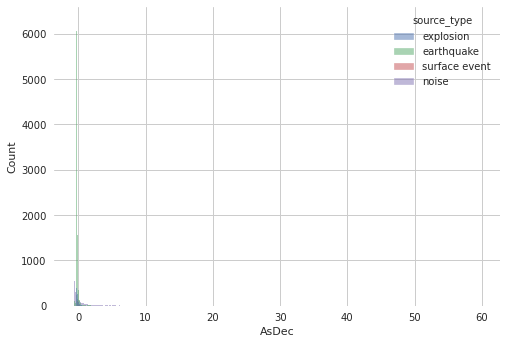

In [78]:
import seaborn as sns
sns.histplot(data= X_final.drop_index(reset = True), x="AsDec", hue="source_type")

In [76]:
X_final

,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,serial_no,source,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,source_horizontal_uncertainty_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_arrival_uncertainty_s,trace_P_arrival_uncertainty_s,trace_P_polarity,trace_S_onset,trace_P_onset,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,hour_of_day,day_of_week,month_of_year
uw10566988,-0.196242,0.987167,0.000739,-0.126197,1.000340,0.443970,1.705251,0.622055,-0.625506,0.030609,-0.017255,-0.000169,-0.278452,-0.844515,-0.628838,-0.882873,-0.109175,-0.345254,-0.296734,-0.244013,-0.450838,-0.126293,-0.745521,-0.833902,-0.584566,-0.270699,-0.208550,-0.336577,-0.244961,0.640862,0.015856,-0.403827,-0.409239,-0.015654,0.082575,0.566919,-0.173155,-0.498332,-0.676010,0.956349,-0.391945,-0.598565,-0.601347,-1.195737,-1.800170,-2.319160,-0.562280,-0.869408,-0.874937,-0.869407,0.206400,-0.641896,1.977460,-0.643735,0.521892,-1.316308,2.065109,-1.485223,1.246482,0,explosion,uw10566988,2002-09-23T19:06:12.980000Z,46.368,-121.182,explosion,-1.094,2.2,md,0.04,0.28,0.092,UW,EH,WPW,--,46.699,-121.537,1280.0,"bucket2$1,:3,:15001",100,2002-09-23T19:05:22.980000Z,6540.0,5812.0,0.05,0.01,undecidable,NaN,NaN,nan|nan|19.454,px,NaN,NaN,2.2,0.04,NaN,2.0,1.0,11.0,0,9
uw10564123,-0.196242,-0.332893,-0.005255,0.200120,-0.469949,-0.733533,0.042752,-0.388735,-1.190032,0.304155,-0.303635,-0.000105,0.283067,-0.080159,0.141590,-0.442522,-0.554110,0.828574,-1.236090,-1.204307,-0.691910,-0.922527,-0.531461,-0.033438,-0.572333,-0.381362,-0.201811,-0.940347,-1.144226,0.634005,-0.202712,0.209814,-0.374574,-0.501276,0.990185,2.438421,-1.410532,-1.841586,0.297418,0.956349,-0.258124,-0.079305,-0.080443,-0.424428,-1.134155,-1.203271,1.232773,-0.144637,-0.149795,-0.144636,0.994839,-0.106387,0.481088,0.481017,-0.212430,0.345213,-0.561743,-0.514495,-0.699955,1,explosion,uw10564123,2002-09-16T20:16:49.720000Z,45.981,-118.330,explosion,1.731,2.5,md,0.04,2.49,3.516,UW,EH,CRF,--,46.825,-119.388,189.0,"bucket9$6,:3,:15001",100,2002-09-16T20:15:59.720000Z,8771.0,7209.0,0.07,0.05,undecidable,NaN,NaN,nan|nan|16.971,px,NaN,NaN,2.5,0.04,NaN,2.0,1.0,12.0,0,9
uw10553573,-0.196242,0.458227,-0.001966,0.501299,-0.227429,0.044746,0.061601,0.425094,-1.928793,-0.004490,0.102596,0.001863,0.792213,-0.718002,-0.074063,-0.842841,-0.714431,2.890767,-2.117546,-2.098876,1.437437,-0.695031,-0.305868,-0.679316,-0.833038,-0.450208,-0.152225,-1.852411,-2.058548,0.146610,0.886818,1.049389,2.759284,-0.986899,-0.825035,-0.836708,-0.117915,-0.162519,-0.189296,-0.385905,-0.010161,-0.117882,-0.124759,-0.784542,-0.297642,-0.843514,2.461561,-0.517934,-0.523284,-0.517934,1.466980,0.456414,0.740736,0.313524,0.443421,-1.213055,0.009333,-1.314825,-0.376259,2,explosion,uw10553573,2002-05-11T21:22:00.540000Z,46.827,-117.182,explosion,-0.503,2.7,md,0.06,0.54,

## So X_final that contains the features and corresponding metadata information for all the events

### hyperparameter tuning of the model based on 3000 samples per class and splitting into 80-20%.

In [58]:
# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=10, verbose=0, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)




Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}
Best Accuracy: 0.914504312957
Test Accuracy: 0.92375


### Performance with best model

Text(0.5, 1.0, 'Total samples: 2400')

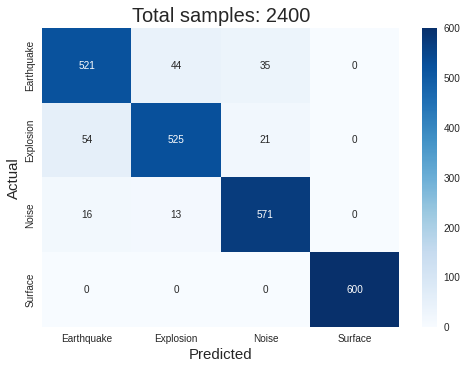

In [59]:
## Performance with best model

plt.style.use('seaborn')
cm = confusion_matrix(y_test, y_pred)


labels = ['Earthquake', 'Explosion','Noise','Surface']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)



### Classification report with best model

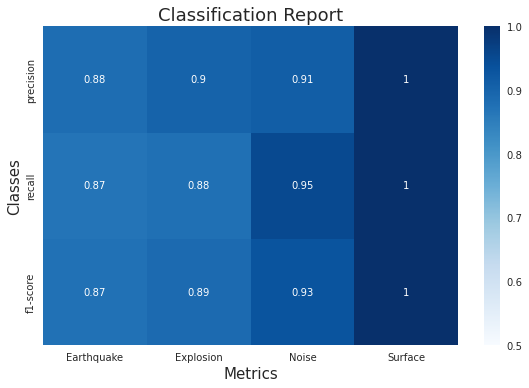

In [60]:
# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
labels = ['Earthquake', 'Explosion', 'Noise','Surface']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(report).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.5, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## In the following code, we are randomly selecting 5000 "Events" per class,  and separating them from the testing dataset

In [61]:
## extracting metadata information for each kind of source along with features
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']
a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



## extracting the event ids corresponding to each catalog
eq_ids = np.unique(a_eq['event_id'].values)
su_ids = np.unique(a_su['event_id'].values)
no_ids = np.unique(a_no['event_id'].values)
px_ids = np.unique(a_px['event_id'].values)


## defining the events for training and testing in 70:30 ratio


"""

Modifying this section a bit, for a fair comparison to deep neural network. 


train_eq = eq_ids[0:int(0.7*len(eq_ids))]
train_px = px_ids[0:int(0.7*len(px_ids))]
train_su = su_ids[0:int(0.7*len(su_ids))]
train_no = no_ids[0:int(0.7*len(no_ids))]


test_eq = eq_ids[int(0.7*len(eq_ids)):len(eq_ids)]
test_px = px_ids[int(0.7*len(px_ids)):len(px_ids)]
test_su = su_ids[int(0.7*len(su_ids)):len(su_ids)]
test_no = no_ids[int(0.7*len(no_ids)):len(no_ids)]


"""

## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_final.index = X_final['event_id'].values


# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

In [69]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:59]
#x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:59]
#x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



In [74]:
X_train

,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,serial_no,source,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,source_horizontal_uncertainty_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_arrival_uncertainty_s,trace_P_arrival_uncertainty_s,trace_P_polarity,trace_S_onset,trace_P_onset,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,hour_of_day,day_of_week,month_of_year
uw10805878,-0.196242,0.485249,0.015977,-0.018633,-0.256988,-0.400696,0.485626,-0.011775,-1.921824,-0.048664,0.073650,0.000204,-0.087150,-0.748385,-0.342315,-1.152421,-0.715323,1.198416,-1.819747,-1.734324,1.438681,-0.922527,-0.227852,-0.709284,-0.854522,-0.451221,-0.173507,-1.530533,-1.654165,1.048528,-0.251088,2.693150,6.330783,-0.015654,0.082575,0.566919,-0.173155,-0.498332,0.297418,-1.392596,0.444437,-0.435254,-0.438512,0.021778,1.052911,0.825247,0.417210,-0.705326,-0.710771,-0.705325,0.511171,0.142728,1.285959,-0.064135,0.235594,-1.156563,-0.236239,-2.400542,0.847993,29944,earthquake,uw10805878,2010-09-04T11:04:29.810000Z,42.162,-124.585,earthquake,23.172,3.12,ml,0.107,2.30,2.233,TA,BH,L02D,--,42.158,-123.603,458.0,"bucket4$3143,:3,:15001",100,2010-09-04T11:03:39.810000Z,7392.0,6392.0,0.08,0.03,positive,NaN,NaN,30.492|30.317|20.174,eq,3.12,0.107,2.9,0.040,NaN,0.0,0.0,3.0,5,9
uw10684978,-0.196242,1.306816,0.002141,-0.296762,0.754940,0.681289,-0.162842,0.847003,0.991406,0.003336,0.012095,0.004449,-0.303466,-0.749903,-0.720424,-0.015515,-0.197652,-0.669784,1.167364,1.344061,-0.811127,1.238677,-0.835042,-0.754297,-0.359952,-0.327296,-0.186498,1.408985,1.379114,0.476083,0.668164,-0.663576,-0.510191,0.469968,-0.825035,-0.368832,1.373566,0.583734,-0.676010,2.298603,-0.595353,-0.609786,-0.612224,1.095976,0.211794,1.021775,-0.186084,-0.881237,-0.886773,-0.881237,-0.412824,-0.854378,-0.093379,-1.193022,0.170305,-1.066324,0.621604,-0.579036,1.496460,8688,earthquake,uw10684978,2005-10-22T15:10:05.390000Z,46.937,-121.971,earthquake,10.971,0.40,md,0.030,1.10,0.559,UW,EH,FMW,--,46.941,-121.671,1859.0,"bucket10$879,:3,:15001",100,2005-10-22T15:09:15.390000Z,5738.0,5424.0,0.01,0.01,positive,NaN,NaN,nan|nan|27.026,eq,NaN,NaN,0.4,0.030,NaN,2.0,0.0,7.0,5,10
uw10684978,-0.196242,0.758971,-0.004491,-0.229181,0.265784,1.663283,0.823762,1.494961,0.371125,0.012632,-0.002666,0.000405,-0.118071,-0.556056,-0.645868,-0.314420,1.331405,-0.649839,0.348548,0.186008,-0.723189,2.148658,-0.656051,-0.577856,-0.063583,0.315749,-0.179960,0.061943,0.174441,1.626922,1.856792,-1.041109,-0.514195,-0.501276,-0.371230,0.566919,-0.147160,-0.834146,0.297418,0.285222,-0.110216,-0.582032,-0.583754,0.342165,-0.596910,-0.189918,1.344997,-0.696752,-0.702193,-0.696752,-0.143556,-0.219938,-0.207568,-0.434061,1.926809,-0.543311,0.669863,-0.113616,0.511708,8689,earthquake,uw10684978,2005-10-22T15:10:05.390000Z,46.937,-121.971,earthquake,10.971,0.40

## Training the model on 5000 randomly samples waveforms per class and testing it on the remaining dataset

In [70]:
# initiating a random undersampler
rus = RandomUnderSampler(sampling_strategy={'earthquake':5000, 'explosion':5000,'surface event':5000,'noise':5000}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)




RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       n_estimators=200, random_state=42)

## Trace wise performance

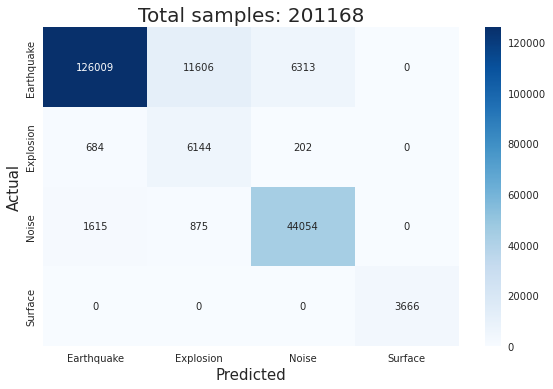

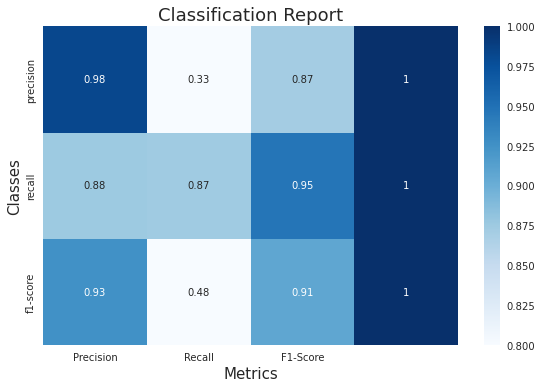

In [71]:
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy = confusion_matrix(y_num_test, y_pred)


labels = ['Earthquake', 'Explosion','Noise','Surface']
plt.figure()
sns.heatmap(trace_cm_phy, annot=True, cmap='Blues', fmt='d', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)
# Adjust layout
plt.tight_layout()



# Calculate the classification report
trace_report_phy = classification_report(y_num_test, y_pred, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(trace_report_phy).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Event wise performance

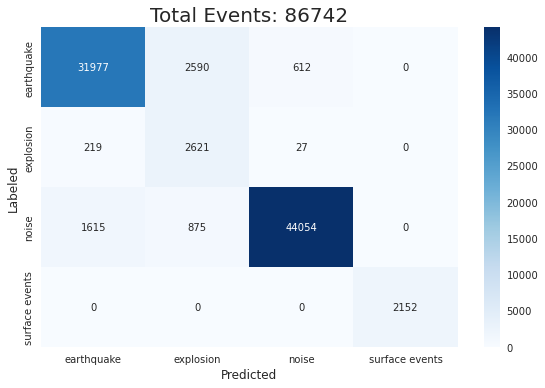

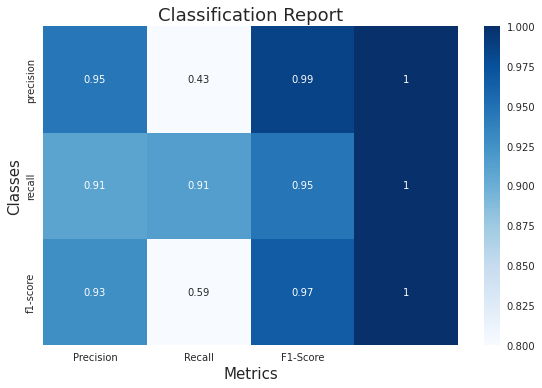

In [72]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_phy = confusion_matrix(mean_labels, temp_class)
cf_norm = cf_events_phy/np.sum(cf_events_phy, axis = 1, keepdims = True)
labels = ['earthquake','explosion','noise','surface events']

plt.figure()
ax = sns.heatmap(cf_events_phy, annot = True, cmap='Blues', xticklabels = labels, yticklabels = labels,  fmt="1.0f")
ax.set_xlabel('Predicted', fontsize = 12)
ax.set_ylabel('Labeled', fontsize = 12)
ax.set_title('Total Events: '+str(len(mean_labels)), fontsize = 20)
plt.tight_layout()




# Calculate the classification report
report_event_phy = classification_report(mean_labels, temp_class, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(report_event_phy).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Saving results of different models

In [ ]:
# Saving every result into disk

# Saving trace results

## physical 
# Save to a file
with open('../Results/trace_report_phy.pkl', 'wb') as pickle_file:
    pickle.dump(trace_report_phy, pickle_file)

    
# Save to a file
with open('../Results/trace_confusion_matrix_phy.pkl', 'wb') as pickle_file:
    pickle.dump(trace_cm_phy, pickle_file)
    
    

# Saving event results

with open('../Results/event_report_phy.pkl', 'wb') as pickle_file:
    pickle.dump(report_event_phy, pickle_file)

    

with open('../Results/event_confusion_matrix_phy.pkl', 'wb') as pickle_file:
    pickle.dump(cf_events_phy, pickle_file)

    


In [73]:
X_test

,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,serial_no,source,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,source_horizontal_uncertainty_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_arrival_uncertainty_s,trace_P_arrival_uncertainty_s,trace_P_polarity,trace_S_onset,trace_P_onset,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,hour_of_day,day_of_week,month_of_year,labelled,classified,eq_probability,px_probability,no_probability,su_probability
uw10547658,-0.196242,2.499933,0.009751,-0.268806,1.196043,1.614275,-1.463761,1.415286,-0.116736,0.003229,0.012956,0.003062,-0.257626,-0.923922,-0.678549,-0.071560,-0.310343,-0.170849,0.077119,0.163103,-0.737165,0.101202,-0.901226,-0.918479,-0.568165,-0.382680,-0.212865,-0.012899,-0.117875,1.663459,1.887977,-0.919651,-0.502995,-1.472521,-1.278840,-0.836708,-0.084771,-0.557593,-0.189296,1.627476,-0.441401,-0.592424,-0.595648,-1.108142,-0.561494,-1.299729,0.158977,-0.948395,-0.953964,-0.948394,-0.297094,-1.151873,0.803717,-1.453070,0.804672,-1.398960,1.058752,-1.308750,0.358895,2113,earthquake,uw10547658,2002-01-01T17:06:17.510000Z,47.931,-124.079,earthquake,33.773,0.9,md,0.05,0.77,0.730,UW,EH,OBC,--,48.035,-124.079,938.0,"bucket7$222,:3,:15001",100,2002-01-01T17:05:27.510000Z,5973.0,5535.0,0.07,0.01,negative,NaN,NaN,nan|nan|29.909,eq,NaN,NaN,0.9,0.05,NaN,2.0,0.0,9.0,1,1,0,0,0.918233,0.033490,0.012027,0.036250
uw10547658,-0.196242,0.554461,-0.004198,-0.159043,0.278707,0.991432,1.372028,1.038258,-0.416423,0.021266,-0.010907,0.000141,-0.213111,-0.810268,-0.583942,0.008504,-0.064923,-0.035666,-0.457257,-0.483990,-0.618893,0.328697,-0.789618,-0.803957,-0.517923,-0.263770,-0.037119,-0.443847,-0.529969,1.776022,1.086446,0.018760,-0.502714,-0.015654,-2.186450,-0.836708,3.056262,0.627631,-0.676010,0.285222,-0.258124,-0.528016,-0.531667,-0.224343,-1.162879,-1.068459,0.155691,-0.744197,-0.749663,-0.744197,0.101736,-0.078943,-0.391692,-0.400007,-0.093190,-0.828311,0.464281,-0.680651,-0.005532,2114,earthquake,uw10547658,2002-01-01T17:06:17.510000Z,47.931,-124.079,earthquake,33.773,0.9,md,0.05,0.77,0.730,UW,EH,OCP,--,48.298,-124.625,487.0,"bucket1$225,:3,:15001",100,2002-01-01T17:05:27.510000Z,6779.0,5988.0,0.04,0.02,negative,NaN,NaN,nan|nan|15.963,eq,NaN,NaN,0.9,0.05,NaN,2.0,0.0,9.0,1,1,0,0,0.740802,0.229037,0.025161,0.005000
uw10547658,-0.196242,2.164043,0.011197,-0.240313,0.609852,1.359678,-1.343032,1.295990,0.127195,0.003642,0.011924,0.006158,-0.189895,-0.866180,-0.627589,0.958595,-0.598589,0.086597,-0.140497,0.028423,-0.751916,-0.012546,-0.878094,-0.848868,-0.671431,-0.426400,-0.199490,0.300080,0.149356,0.852004,0.245982,-0.006645,-0.466844,-0.015654,-0.825035,0.566919,0.876405,-0.498332,1.270846,-1.392596,0.645169,-0.578258,-0.581144,-0.836566,-0.828492,-1.291759,0.697556,-0.907093,-0.912642,-0.907093,-0.185514,-0.667666,0.081612